# Figure 1 - study area

This notebook shows the study area. <br />
&nbsp; a) The study location within Europe. <br />
&nbsp; b) The landcover in and surrounding the study area.

In [3]:
#### TODO: remove probability map (formally map b)
#### add data sources?

#### global import statements

In [6]:
from matplotlib import pyplot
%matplotlib inline
import pyproj

In [7]:
from os import path

In [8]:
from django.db import connection

#### supress warnings

In [9]:
#import warnings
#warnings.filterwarnings('ignore')

In [10]:
#from rasterio import logging

#log = logging.getLogger()
#log.setLevel(logging.ERROR)

#### set coordinate systems

In [11]:
austria_mgd = pyproj.Proj(init='epsg:31254')

#### function declarations

In [12]:
def get_geodataframe(queryset, modification=None, crs=austria_mgd):
    query = queryset.query.sql_with_params()
    if modification:
        query = (modification, query[1])
    return geopandas.read_postgis(query[0], connection, 
                                   geom_col='geometry', 
                                   params=query[1], 
                                   index_col='id',
                                   crs=crs)

In [13]:
def get_landcover(point, radius=100):
    buffer = point.buffer(radius)
    result = LandCover.objects.filter(geometry__intersects=buffer.envelope)\
                          .annotate(intersection=Intersection('geometry', buffer.envelope))#.aggregate(total=Collect('intersection'))
    return result

In [14]:
def save_figures(directory, figures, file_type='tiff', dpi=300):
    for figure in figures:
        eval(figure).savefig(path.join(directory, "{0}.{1}".format(figure, file_type)), dpi=dpi)

#### variable definitions

In [15]:
figure_directory = ""

#### define formating settings

In [16]:
from matplotlib import rcParams

In [17]:
rcParams['font.sans-serif']

['Bitstream Vera Sans',
 'DejaVu Sans',
 'Lucida Grande',
 'Verdana',
 'Geneva',
 'Lucid',
 'Arial',
 'Helvetica',
 'Avant Garde',
 'sans-serif']

In [18]:
rcParams['font.sans-serif'] = ['Helvetica',
                               'Arial',
                               'Bitstream Vera Sans',
                               'DejaVu Sans',
                               'Lucida Grande',
                               'Verdana',
                               'Geneva',
                               'Lucid',
                               'Avant Garde',
                               'sans-serif']

#### import statements

In [19]:
import rasterio
from geo.models import LandCoverType
from landscape.models import LandCoverTypeMap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import Greys
from matplotlib.lines import Line2D

In [20]:
import numpy
import pandas
from database.models import Site
from geo.models import SampleLocation, Boundary
from geo.models import Raster
import geopandas

In [21]:
from scalebars import add_scalebar

In [22]:
def multi_annotate(ax, s, xy_list=[], *args, **kwargs):
    ans = []
    an = ax.annotate(s, xy_list[0], *args, **kwargs)
    ans.append(an)
    d = {}
    try:
        d['xycoords'] = kwargs['xycoords']
    except KeyError:
        pass
    try:
        d['arrowprops'] = kwargs['arrowprops']
    except KeyError:
        pass
    for xy in xy_list[1:]:
        an = ax.annotate(s, xy, alpha=0.0, xytext=(0,0), textcoords=an, **d)
        ans.append(an)
    return ans

In [23]:
boundary = get_geodataframe(Boundary.objects.filter(name__exact='study area'))
generated = get_geodataframe(SampleLocation.objects.all())
acutal = get_geodataframe(Site.objects.filter(id__lte=30))

In [24]:
area_percentages = pandas.read_csv("/Users/Jake/OneDrive/Documents/alpine soundscapes/data/landcover/area_percentages.csv").set_index('id')

osm roads data

In [2]:
#### TODO: put road data into PostGIS?

In [25]:
roads_filpath = "/Users/Jake/Documents/research/alpine soundscapes/GIS/Flat_files/shapefile/highway.shp"
roads = geopandas.read_file(roads_filpath)

In [26]:
roads.Type.unique()

array(['primary', 'residential', 'footway', 'service', 'path', 'motorway',
       'track', 'unclassified', 'tertiary', 'cycleway', 'primary_link',
       'secondary', 'motorway_link', 'living_street', 'steps',
       'tertiary_link', 'pedestrian', 'secondary_link', 'construction',
       'platform', 'services', 'rest_area', 'bus_stop', 'escape',
       'elevator', 'proposed', 'crossing'], dtype=object)

In [27]:
motorway = roads[roads.Type.isin(['motorway', 'motorway_link'])]
primary = roads[roads.Type.isin(['primary', 'primary_link'])]
secondary = roads[roads.Type.isin(['secondary', 'secondary_link'])]
tertiary = roads[roads.Type.isin(['teritary', 'tertiary_link'])]
residential = roads[roads.Type == 'residential']
unclassified = roads[roads.Type == 'unclassified']

In [28]:
hillshade = Raster.objects.get(name='hillshade')
landcover = Raster.objects.get(name='landcover merged publication')

read raster data

In [29]:
with rasterio.open(path=hillshade.filepath, mode='r') as source:
    hillshade = {'data': source.read(1)}
    hillshade['extent'] = [source.bounds.left, source.bounds.right, source.bounds.bottom, source.bounds.top]
    source.close()
with rasterio.open(path=landcover.filepath, mode='r') as source:
    landcover = {'data': numpy.ma.masked_equal(source.read(1), value=source.nodata)}
    landcover['extent'] = [source.bounds.left, source.bounds.right, source.bounds.bottom, source.bounds.top]
    source.close()

plot

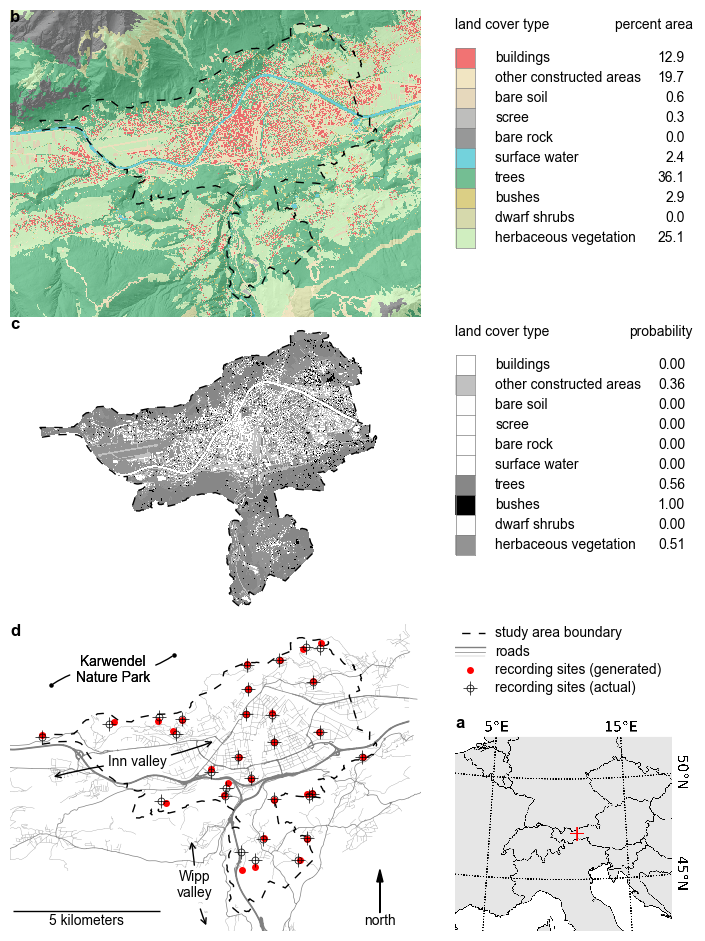

In [30]:
figure1 = pyplot.figure()
figure1.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

figure1.set_figheight(9.21)
figure1.set_figwidth(6.85)

ax_a = pyplot.subplot2grid((30, 20), (0, 0), rowspan=10, colspan=12)
ax_l = pyplot.subplot2grid((30, 20), (0, 13), rowspan=9, colspan=7)
ax_b = pyplot.subplot2grid((30, 20), (10, 0), rowspan=10, colspan=12, sharex=ax_a, sharey=ax_a)
ax_bl = pyplot.subplot2grid((30, 20), (10, 13), rowspan=9, colspan=7, sharex=ax_l)
ax_c = pyplot.subplot2grid((30, 20), (20, 0), rowspan=10, colspan=12, sharex=ax_a, sharey=ax_a)
ax_cl = pyplot.subplot2grid((30, 20), (20, 13), rowspan=3, colspan=7, sharex=ax_l)
ax_in = pyplot.subplot2grid((30, 20), (23, 13), rowspan=7, colspan=7)

# title formatting
title_font = {
    'size': 12.0,
    'weight': 'bold'
}

# formatting
ax_a.set_frame_on(False)
ax_a.tick_params(axis='both', 
                 bottom=False, right=False, top=False, left=False,
                 labelbottom=False, labelleft=False)

# landcover colormap
color_list = [t['color'] for t in LandCoverType.objects.all().order_by('id').values()]
landcover_colormap = LinearSegmentedColormap.from_list(name='landcover', colors=color_list)

# probability colormap
prob_colormap = Greys
prob_colormap.set_under(color='white')

# plot rasters
a_hillshade = ax_a.imshow('data', extent='extent', interpolation='none', data=hillshade, cmap='gray', alpha=0.5)
a_landcover = ax_a.imshow('data', extent='extent', interpolation='none', data=landcover, cmap=landcover_colormap, vmin=1, vmax=15, alpha=0.5)
a_boundary = boundary.plot(ax=ax_a, facecolor='none', edgecolor='black', linestyle='--', linewidth=1, label='study area')

# set plot limits
ax_a.set_xlim([72500, 86500])
ax_a.set_ylim([230500, 240500])

# title
ax_a.text(0, 1, 'b', horizontalalignment='left', verticalalignment='top', 
          fontdict=title_font,
          transform=ax_a.transAxes)

#----- legend -----
type_array = numpy.array([1, 2, 3, 4, 5, 6, 9, 10, 11, 12]).reshape(10, 1)
type_array_background = numpy.ones(10).reshape(10, 1) * 0.5
ax_l.imshow(type_array_background, cmap='gray', vmin=0, vmax=1, interpolation='none', alpha=0.2)
ax_l.imshow(type_array, cmap=landcover_colormap, vmin=1, vmax=15, interpolation='none', alpha=0.5)
ax_l.set_xlim([-0.5, 11.5])
ax_l.add_line(Line2D([-0.485, -0.485], [-0.5, 9.5], color='gray', linewidth=0.5))
ax_l.add_line(Line2D([0.5, 0.5], [-0.5, 9.5], color='gray', linewidth=0.5))
for i in range(11):
    ax_l.add_line(Line2D([-0.485, 0.5], [i - 0.5, i - 0.5], color='gray', linewidth=0.5))

# formatting
ax_l.set_frame_on(False)
ax_l.set_aspect('equal')
ax_l.tick_params(axis='both', 
               bottom=False, right=False, top=False, left=False,
               labelbottom=False, labelleft=False)

# labels
for i, label in enumerate([r['name'] for r in LandCoverType.objects.filter(id__in=type_array).values()]):
    t0 = ax_l.text(1.5, i + 0.2, label.lower())
for i, a in enumerate(area_percentages['study_area'].iloc[type_array.ravel() - 1]):
    t1 = ax_l.text(11, i + 0.2, "{0:0.1f}".format(a), horizontalalignment='right')

#-------------------------------------------------------
r0 = motorway.plot(ax=ax_c, color='gray', linewidth=1)
r1 = primary.plot(ax=ax_c, color='gray', linewidth=0.5)
r2 = secondary.plot(ax=ax_c, color='gray', linewidth=0.5)
r3 = tertiary.plot(ax=ax_c, color='gray', linewidth=0.2)
r4 = residential.plot(ax=ax_c, color='gray', linewidth=0.2)
r5 = unclassified.plot(ax=ax_c, color='gray', linewidth=0.2)
p0 = boundary.plot(ax=ax_c, facecolor='none', edgecolor='black', linestyle='--', linewidth=1)
p1 = generated.plot(ax=ax_c, color='red', marker='o', alpha=1, markersize=5, markeredgecolor='none')
p2 = acutal.plot(ax=ax_c, color='black', marker='o', markersize=5, markerfacecolor='none')
p2 = acutal.plot(ax=ax_c, color='black', marker='+', markersize=10, markerfacecolor='none')
ax_c.set_frame_on(False)
ax_c.tick_params(axis='both', 
               bottom=False, right=False, top=False, left=False,
               labelbottom=False, labelleft=False)
ax_c.text(0, 1, 'd', horizontalalignment='left', verticalalignment='top', 
          fontdict=title_font, 
          transform=ax_c.transAxes)

#----- legend -----
ax_cl.tick_params(axis='both', 
               bottom=False, right=False, top=False, left=False,
               labelbottom=False, labelleft=False)
ax_cl.set_frame_on(False)
ax_cl.set_ylim([0, 1])
l3 = ax_cl.plot([-1.0, 1.0], [0.9, 0.9], color='black', markerfacecolor='none', markeredgecolor='black', linestyle='--', linewidth=1)
l3 = ax_cl.plot([-1.0, 1.0], [0.75, 0.75], color='gray', markerfacecolor='none', markeredgecolor='black', linewidth=1)
l3 = ax_cl.plot([-1.0, 1.0], [0.70, 0.70], color='gray', markerfacecolor='none', markeredgecolor='black', linewidth=0.5)
l3 = ax_cl.plot([-1.0, 1.0], [0.65, 0.65], color='gray', markerfacecolor='none', markeredgecolor='black', linewidth=0.2)
l1 = ax_cl.plot(0.25, 0.5, color='red', marker='o', alpha=1, markersize=5, markeredgecolor='none')
l2 = ax_cl.plot(0.25, 0.3, color='black', marker='o', markersize=5, markerfacecolor='none')
l3 = ax_cl.plot(0.25, 0.3, color='black', marker='+', markersize=10, markerfacecolor='none')

t1 = ax_cl.text(1.5, 0.9, 'study area boundary', va='center')
t1 = ax_cl.text(1.5, 0.7, 'roads', va='center')
t1 = ax_cl.text(1.5, 0.5, 'recording sites (generated)', va='center')
t1 = ax_cl.text(1.5, 0.3, 'recording sites (actual)', va='center')

#-------------------------------------------------------
b_probability = ax_b.imshow('data', extent='extent', interpolation='none', data=probability, cmap=prob_colormap, alpha=1, vmin=0.01, vmax=1)
b_boundary = boundary.plot(ax=ax_b, facecolor='none', edgecolor='black', linestyle='--', linewidth=1, label='study area')

#----- legend -----
probability_array = numpy.array([0, 0.3626, 0, 0, 0, 0, 0.5556, 1.0, 0, 0.5134]).reshape(10, 1)
ax_bl.imshow(probability_array, cmap=prob_colormap, vmin=0.01, vmax=1, interpolation='none')
ax_bl.set_xlim([-0.5, 11.5])
ax_bl.add_line(Line2D([-0.485, -0.485], [-0.5, 9.5], color='gray', linewidth=0.5))
ax_bl.add_line(Line2D([0.5, 0.5], [-0.5, 9.5], color='gray', linewidth=0.5))
for i in range(11):
    ax_bl.add_line(Line2D([-0.485, 0.5], [i - 0.5, i - 0.5], color='gray', linewidth=0.5))

# formatting
ax_bl.set_frame_on(False)
ax_bl.set_aspect('equal')
ax_bl.tick_params(axis='both', 
               bottom=False, right=False, top=False, left=False,
               labelbottom=False, labelleft=False)

# labels
for i, label in enumerate([r['name'] for r in LandCoverType.objects.filter(id__in=type_array).values()]):
    t0 = ax_bl.text(1.5, i + 0.2, label.lower())
for i, p in enumerate(probability_array.ravel()):
    t1 = ax_bl.text(11, i + 0.2, "{0:0.2f}".format(p), horizontalalignment='right')

# formatting
ax_b.text(0, 1, 'c', horizontalalignment='left', verticalalignment='top', 
          fontdict=title_font, 
          transform=ax_b.transAxes)
ax_b.set_frame_on(False)
ax_b.tick_params(axis='both', 
                 bottom=False, right=False, top=False, left=False,
                 labelbottom=False, labelleft=False)

scale_bar = add_scalebar(ax_c, matchx=False, matchy=False, labely=None, sizey=None, labelx='5 kilometers', sizex=5000, loc=3)
dx = 0
dy = 0.1
arrow = ax_c.arrow(0.9, 0.06, dx, dy, fc="k", ec="k", linewidth = 1, head_width=0.015, head_length=0.04, transform=ax_c.transAxes)
north = ax_c.text(0.9, 0.01, 'north', ha='center', va='bottom', transform=ax_c.transAxes)

#inset
ax_in.imshow(pyplot.imread(path.join(figure_directory, "figure1a.png")))
ax_in.text(0, 1, 'a', horizontalalignment='left', verticalalignment='top', 
          fontdict=title_font, 
          transform=ax_in.transAxes)
ax_in.set_frame_on(False)
ax_in.set_aspect('equal')
ax_in.tick_params(axis='both', 
                 bottom=False, right=False, top=False, left=False,
                 labelbottom=False, labelleft=False)

# legend titles
lt1 = ax_l.text(0, 0.93, "land cover type", transform=ax_l.transAxes)
lt2 = ax_l.text(0.99, 0.93, "percent area", horizontalalignment='right', transform=ax_l.transAxes)
lt3 = ax_bl.text(0, 0.93, "land cover type", transform=ax_bl.transAxes)
lt3 = ax_bl.text(0.99, 0.93, "probability", horizontalalignment='right', transform=ax_bl.transAxes)

# place labels
an = ax_c.annotate("Karwendel\nNature Park", xy=(0.10, 0.80), xytext=(0.25, 0.85), xycoords=ax_c.transAxes,
               ha='center', va='center', 
               arrowprops=dict(arrowstyle='-',
                               connectionstyle='arc3,rad=0.2'))
an = ax_c.annotate("Karwendel\nNature Park", xy=(0.40, 0.90), xytext=(0.25, 0.85), xycoords=ax_c.transAxes,
               ha='center', va='center', 
               arrowprops=dict(arrowstyle='-',
                               connectionstyle='arc3,rad=0.2'))
ax_c.scatter([0.1, 0.4], [0.80, 0.90], c='black', marker='o', s=5, transform=ax_c.transAxes)
bbox_props = dict(boxstyle="round,pad=0.1", fc='white', ec='white')
an = ax_c.annotate("Inn valley", xy=(0.10, 0.50), xytext=(0.31, 0.55), xycoords=ax_c.transAxes,
               ha='center', va='center', bbox=bbox_props,
               arrowprops=dict(arrowstyle='->',
                               connectionstyle='arc3,rad=0.05'))
an = ax_c.annotate("Inn valley", xy=(0.50, 0.62), xytext=(0.31, 0.55), xycoords=ax_c.transAxes,
               ha='center', va='center', bbox=bbox_props,
               arrowprops=dict(arrowstyle='->',
                               connectionstyle='arc3,rad=0.05'))
an = multi_annotate(ax_c, 'Wipp\nvalley', xy_list=[(0.44, 0.30), (0.48, 0.01)], xytext=(0.45, 0.15), xycoords=ax_c.transAxes,
               ha='center', va='center', bbox=bbox_props,
               arrowprops=dict(arrowstyle='->',
                               connectionstyle='arc3,rad=0.05'))